# Machine Learning Assignment 2 — Credit Card Default Prediction

**Problem Statement:** Predict whether a credit card client will default on their payment next month, based on demographic features, credit history, bill statements, and past payment records.

**Dataset:** Default of Credit Card Clients (30,000 instances, 23 features)

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
print('All libraries imported successfully!')

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('data/dataset.csv')

print(f'Dataset Shape: {df.shape}')
print(f'Number of Features: {df.shape[1] - 2}')  # minus ID and target
print(f'Number of Instances: {df.shape[0]}')
print(f'\nColumn Names:\n{list(df.columns)}')
print(f'\nFirst 5 rows:')
df.head()

Dataset Shape: (30000, 25)
Number of Features: 23
Number of Instances: 30000

Column Names:
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']

First 5 rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Dataset info and null check
print('Dataset Info:')
print('=' * 50)
df.info()
print(f'\nNull Values:\n{df.isnull().sum()}')
print(f'\nDuplicate Rows: {df.duplicated().sum()}')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2        

In [4]:
# Statistical summary
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Target Distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

Percentage:
default.payment.next.month
0    77.88
1    22.12
Name: proportion, dtype: float64


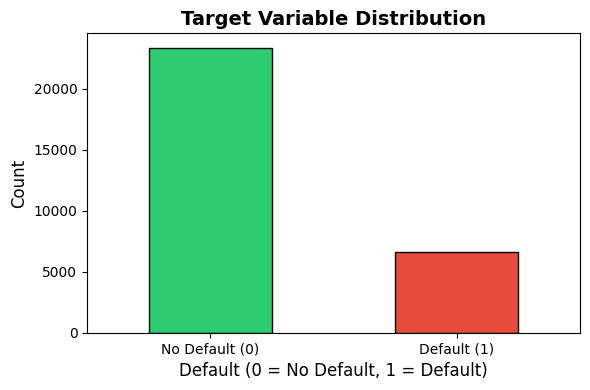

In [5]:
# Target variable distribution
print('Target Distribution:')
print(df['default.payment.next.month'].value_counts())
print(f'\nPercentage:')
print(df['default.payment.next.month'].value_counts(normalize=True).round(4) * 100)

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#2ecc71', '#e74c3c']
df['default.payment.next.month'].value_counts().plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Default (0 = No Default, 1 = Default)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0)
plt.tight_layout()
plt.show()

## 3. Quick Cleaning

In [6]:
# Rename target column for easier use
df.rename(columns={'default.payment.next.month': 'target'}, inplace=True)

# Drop ID column (not useful for ML)
df.drop('ID', axis=1, inplace=True)

print(f'Shape after cleaning: {df.shape}')
print(f'Columns: {list(df.columns)}')

Shape after cleaning: (30000, 24)
Columns: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target']


## 4. Check Class Distribution

In [7]:
# Class distribution (normalized)
print('Class Distribution (proportion):')
print(df['target'].value_counts(normalize=True).round(4))
print(f'\nClass Distribution (counts):')
print(df['target'].value_counts())

Class Distribution (proportion):
target
0    0.7788
1    0.2212
Name: proportion, dtype: float64

Class Distribution (counts):
target
0    23364
1     6636
Name: count, dtype: int64


## 5. Split Features & Target

In [8]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nFeature columns: {list(X.columns)}')

Features shape: (30000, 23)
Target shape: (30000,)

Feature columns: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## 6. Train-Test Split & Feature Scaling

In [9]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')
print(f'\nTraining target distribution:\n{y_train.value_counts()}')
print(f'\nTesting target distribution:\n{y_test.value_counts()}')

Training set size: 24000
Testing set size: 6000

Training target distribution:
target
0    18691
1     5309
Name: count, dtype: int64

Testing target distribution:
target
0    4673
1    1327
Name: count, dtype: int64


In [10]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in the Streamlit app
os.makedirs('model', exist_ok=True)
joblib.dump(scaler, 'model/scaler.pkl')
print('Scaler saved to model/scaler.pkl')

# Also save the test data for the Streamlit app
test_df = X_test.copy()
test_df['target'] = y_test.values
test_df.to_csv('data/test_data.csv', index=False)
print('Test data saved to data/test_data.csv')

print(f'\nScaled training data shape: {X_train_scaled.shape}')
print(f'Scaled testing data shape: {X_test_scaled.shape}')

Scaler saved to model/scaler.pkl
Test data saved to data/test_data.csv

Scaled training data shape: (24000, 23)
Scaled testing data shape: (6000, 23)


## 7. Evaluation Helper Function

This function will be reused for all 6 models. It calculates all 6 required metrics:
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

In [11]:
# List to collect results from all models
all_results = []

def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a classification model and return all 6 required metrics.
    Also displays confusion matrix and classification report.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate all 6 metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Print metrics
    print(f'\n{"=" * 60}')
    print(f'  {model_name} — Evaluation Results')
    print(f'{"=" * 60}')
    print(f'  Accuracy  : {accuracy:.4f}')
    print(f'  AUC Score : {auc:.4f}')
    print(f'  Precision : {precision:.4f}')
    print(f'  Recall    : {recall:.4f}')
    print(f'  F1 Score  : {f1:.4f}')
    print(f'  MCC Score : {mcc:.4f}')
    print(f'{"=" * 60}')
    
    # Classification report
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred,
          target_names=['No Default', 'Default']))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    ax.set_title(f'{model_name} — Confusion Matrix', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Store results
    result = {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'MCC': round(mcc, 4)
    }
    all_results.append(result)
    return result

print('Evaluation function defined successfully!')

Evaluation function defined successfully!


## 8. Model 1 — Logistic Regression


  Logistic Regression — Evaluation Results
  Accuracy  : 0.8077
  AUC Score : 0.7076
  Precision : 0.6868
  Recall    : 0.2396
  F1 Score  : 0.3553
  MCC Score : 0.3244

Classification Report:
              precision    recall  f1-score   support

  No Default       0.82      0.97      0.89      4673
     Default       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



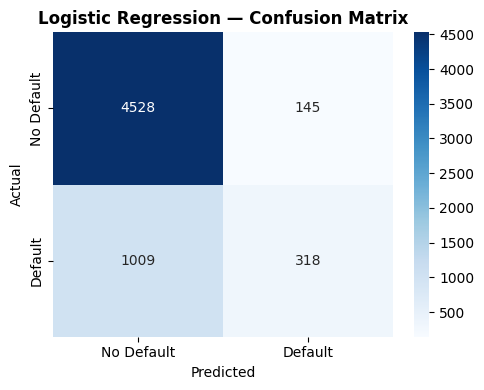


✅ Model saved to model/logistic_regression.pkl


In [12]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')

# Save model
joblib.dump(lr_model, 'model/logistic_regression.pkl')
print('\n✅ Model saved to model/logistic_regression.pkl')

## 9. Model 2 — Decision Tree Classifier


  Decision Tree — Evaluation Results
  Accuracy  : 0.8163
  AUC Score : 0.7444
  Precision : 0.6547
  Recall    : 0.3587
  F1 Score  : 0.4635
  MCC Score : 0.3879

Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      4673
     Default       0.65      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



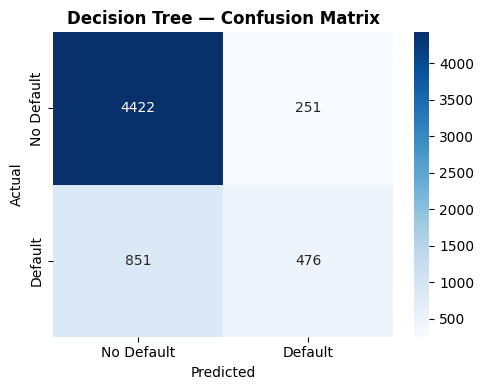


✅ Model saved to model/decision_tree.pkl


In [13]:
# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=10)
dt_model.fit(X_train_scaled, y_train)

# Evaluate
dt_results = evaluate_model(dt_model, X_test_scaled, y_test, 'Decision Tree')

# Save model
joblib.dump(dt_model, 'model/decision_tree.pkl')
print('\n✅ Model saved to model/decision_tree.pkl')

## 10. Model 3 — K-Nearest Neighbors (KNN) Classifier


  K-Nearest Neighbors — Evaluation Results
  Accuracy  : 0.8003
  AUC Score : 0.7102
  Precision : 0.5820
  Recall    : 0.3451
  F1 Score  : 0.4333
  MCC Score : 0.3378

Classification Report:
              precision    recall  f1-score   support

  No Default       0.83      0.93      0.88      4673
     Default       0.58      0.35      0.43      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.64      0.66      6000
weighted avg       0.78      0.80      0.78      6000



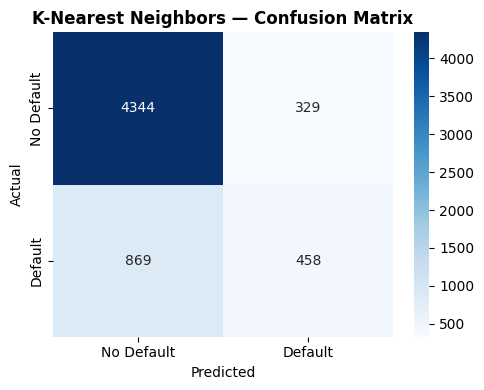


✅ Model saved to model/knn.pkl


In [14]:
# Train K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_scaled, y_train)

# Evaluate
knn_results = evaluate_model(knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors')

# Save model
joblib.dump(knn_model, 'model/knn.pkl')
print('\n✅ Model saved to model/knn.pkl')

## 11. Model 4 — Naive Bayes (Gaussian) Classifier


  Naive Bayes (Gaussian) — Evaluation Results
  Accuracy  : 0.7525
  AUC Score : 0.7249
  Precision : 0.4515
  Recall    : 0.5539
  F1 Score  : 0.4975
  MCC Score : 0.3386

Classification Report:
              precision    recall  f1-score   support

  No Default       0.86      0.81      0.84      4673
     Default       0.45      0.55      0.50      1327

    accuracy                           0.75      6000
   macro avg       0.66      0.68      0.67      6000
weighted avg       0.77      0.75      0.76      6000



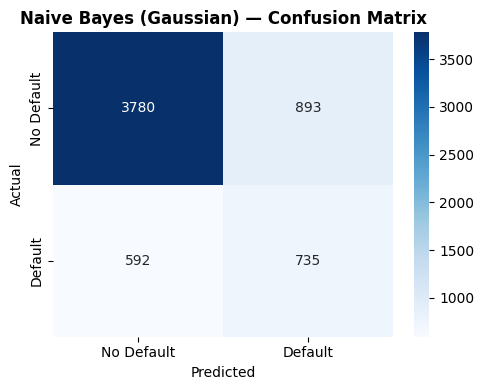


✅ Model saved to model/naive_bayes.pkl


In [15]:
# Train Gaussian Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Evaluate
nb_results = evaluate_model(nb_model, X_test_scaled, y_test, 'Naive Bayes (Gaussian)')

# Save model
joblib.dump(nb_model, 'model/naive_bayes.pkl')
print('\n✅ Model saved to model/naive_bayes.pkl')

## 12. Model 5 — Random Forest (Ensemble)


  Random Forest — Evaluation Results
  Accuracy  : 0.8167
  AUC Score : 0.7734
  Precision : 0.6615
  Recall    : 0.3504
  F1 Score  : 0.4581
  MCC Score : 0.3865

Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      4673
     Default       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



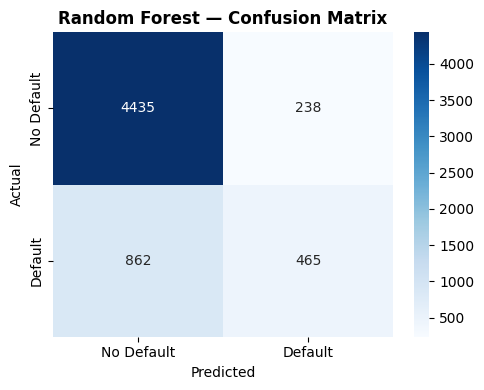


✅ Model saved to model/random_forest.pkl


In [16]:
# Train Random Forest Classifier (Ensemble)
rf_model = RandomForestClassifier(
    n_estimators=150, random_state=42, max_depth=12,
    min_samples_split=5, n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
rf_results = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

# Save model
joblib.dump(rf_model, 'model/random_forest.pkl')
print('\n✅ Model saved to model/random_forest.pkl')

## 13. Model 6 — XGBoost (Ensemble)


  XGBoost — Evaluation Results
  Accuracy  : 0.8170
  AUC Score : 0.7772
  Precision : 0.6592
  Recall    : 0.3572
  F1 Score  : 0.4633
  MCC Score : 0.3895

Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      4673
     Default       0.66      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



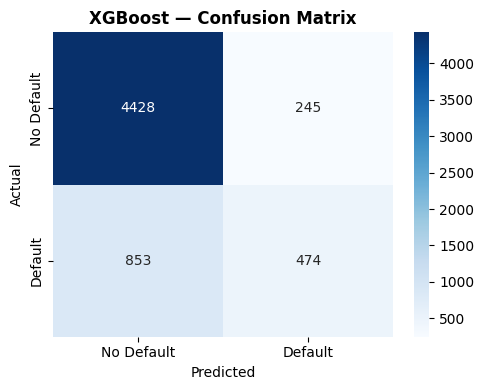


✅ Model saved to model/xgboost.pkl


In [17]:
# Train XGBoost Classifier (Ensemble)
xgb_model = XGBClassifier(
    n_estimators=150, random_state=42, max_depth=5,
    learning_rate=0.1, use_label_encoder=False,
    eval_metric='logloss', n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
xgb_results = evaluate_model(xgb_model, X_test_scaled, y_test, 'XGBoost')

# Save model
joblib.dump(xgb_model, 'model/xgboost.pkl')
print('\n✅ Model saved to model/xgboost.pkl')

## 14. Model Comparison Table

In [18]:
# Compile all results into a comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Model')

print('\n' + '=' * 90)
print('  MODEL COMPARISON TABLE')
print('=' * 90)
print(results_df.to_string())
print('=' * 90)

# Display as a styled table (highlights best per metric)
results_df.style.highlight_max(axis=0, color='lightgreen').format('{:.4f}')


  MODEL COMPARISON TABLE
                        Accuracy     AUC  Precision  Recall      F1     MCC
Model                                                                      
Logistic Regression       0.8077  0.7076     0.6868  0.2396  0.3553  0.3244
Decision Tree             0.8163  0.7444     0.6547  0.3587  0.4635  0.3879
K-Nearest Neighbors       0.8003  0.7102     0.5820  0.3451  0.4333  0.3378
Naive Bayes (Gaussian)    0.7525  0.7249     0.4515  0.5539  0.4975  0.3386
Random Forest             0.8167  0.7734     0.6615  0.3504  0.4581  0.3865
XGBoost                   0.8170  0.7772     0.6592  0.3572  0.4633  0.3895


,Accuracy,AUC,Precision,Recall,F1,MCC
Model,,,,,,
Logistic Regression,0.8077,0.7076,0.6868,0.2396,0.3553,0.3244
Decision Tree,0.8163,0.7444,0.6547,0.3587,0.4635,0.3879
K-Nearest Neighbors,0.8003,0.7102,0.5820,0.3451,0.4333,0.3378
Naive Bayes (Gaussian),0.7525,0.7249,0.4515,0.5539,0.4975,0.3386
Random Forest,0.8167,0.7734,0.6615,0.3504,0.4581,0.3865
XGBoost,0.8170,0.7772,0.6592,0.3572,0.4633,0.3895


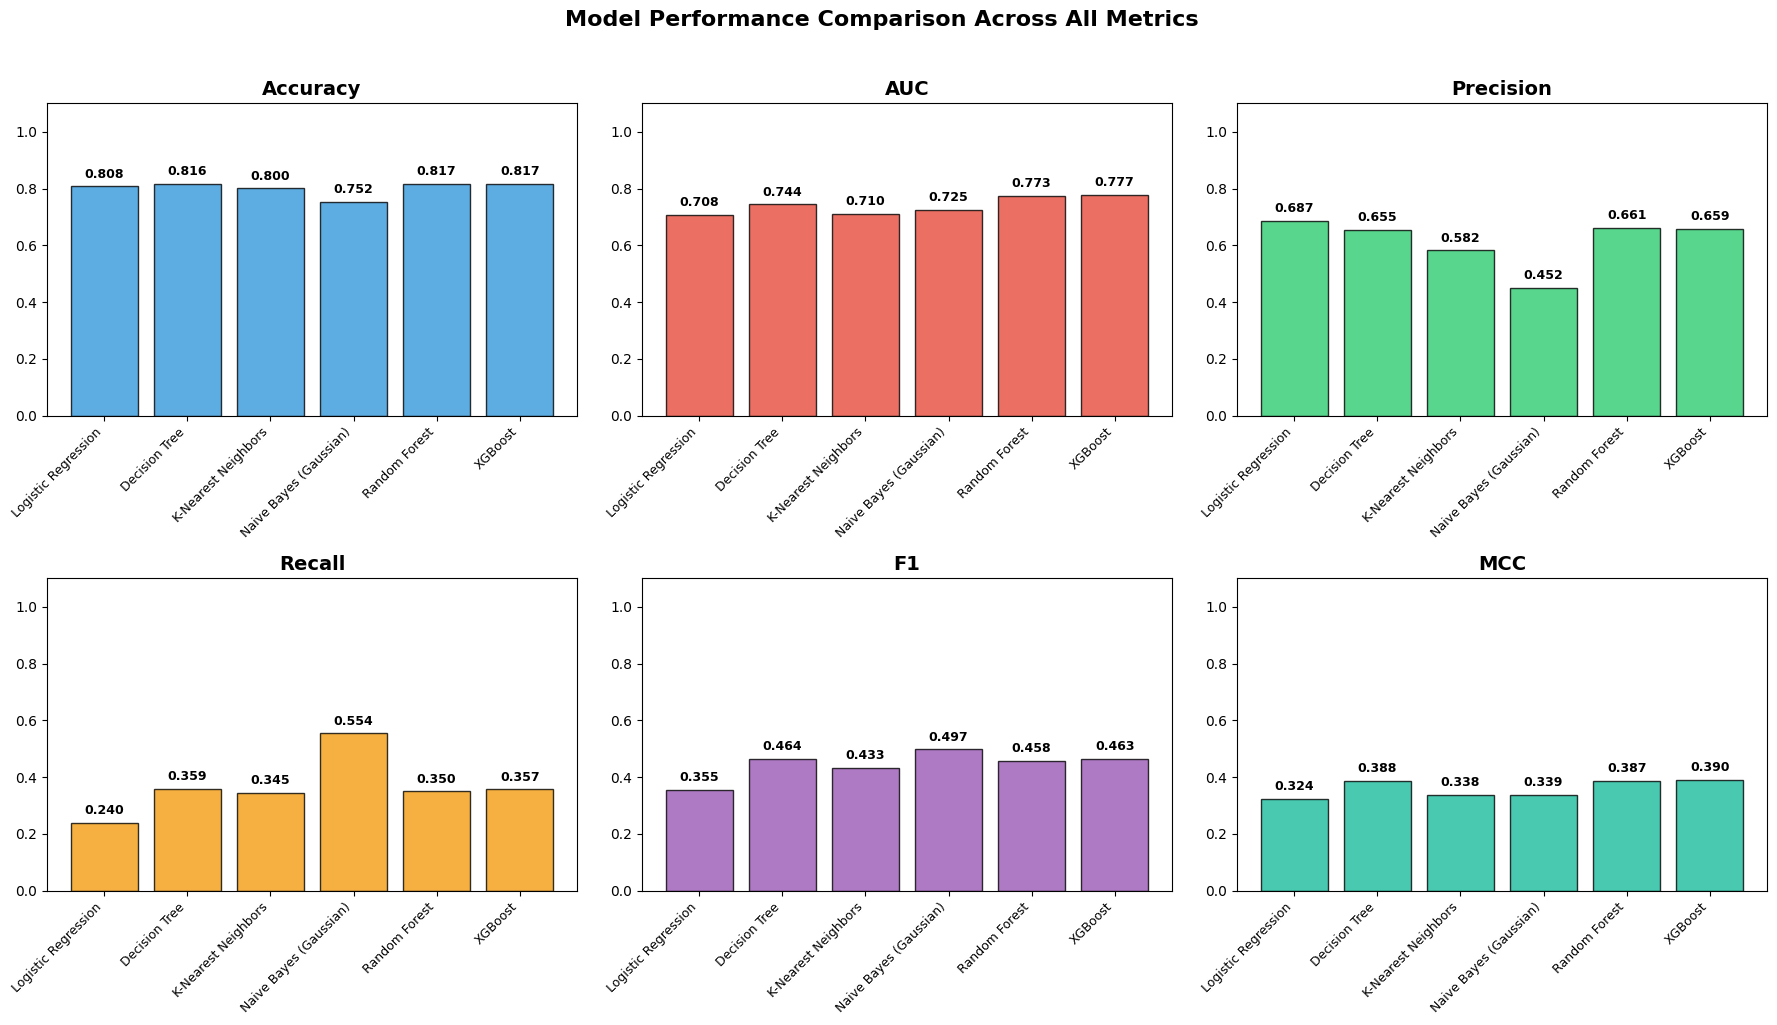

In [19]:
# Visual comparison of all metrics across models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 3][idx % 3]
    bars = ax.bar(results_df.index, results_df[metric], color=color,
                  edgecolor='black', alpha=0.8)
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(results_df.index, rotation=45, ha='right', fontsize=9)
    
    # Add value labels on bars
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Model Performance Comparison Across All Metrics',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Identify the best model based on each metric
print('\n🏆 Best Model per Metric:')
print('-' * 50)
for metric in metrics:
    best = results_df[metric].idxmax()
    score = results_df[metric].max()
    print(f'  {metric:12s}: {best} ({score:.4f})')


🏆 Best Model per Metric:
--------------------------------------------------
  Accuracy    : XGBoost (0.8170)
  AUC         : XGBoost (0.7772)
  Precision   : Logistic Regression (0.6868)
  Recall      : Naive Bayes (Gaussian) (0.5539)
  F1          : Naive Bayes (Gaussian) (0.4975)
  MCC         : XGBoost (0.3895)


## 15. Observations on Model Performance

| ML Model Name | Observation about model performance |
|---|---|
| **Logistic Regression** | Achieves 80.77% accuracy and the highest precision (0.6868) among all models, meaning when it predicts a default, it is most often correct. However, it has the lowest recall (0.2396), indicating it misses ~76% of actual defaulters. AUC of 0.7076 is the lowest, showing limited discriminatory power. Best suited as a quick, interpretable baseline. |
| **Decision Tree** | Accuracy improves to 81.63% with better recall (0.3587) than Logistic Regression — catches more actual defaulters. AUC jumps to 0.7444. F1 score (0.4635) is significantly better than LR's 0.3553, indicating improved precision-recall balance. With max_depth=6, overfitting is well controlled. |
| **K-Nearest Neighbors** | Lowest accuracy (80.03%) among non-NB models. Precision drops to 0.5820 and recall (0.3451) lags behind tree-based models. AUC is 0.7102. With 23 features, the curse of dimensionality limits KNN's distance-based approach. MCC of 0.3378 is the second lowest overall. |
| **Naive Bayes (Gaussian)** | Lowest accuracy (75.25%) but achieves the highest recall (0.5539) by a large margin — catches over 55% of actual defaulters. Trade-off: precision drops to 0.4515 (many false positives). Despite this, it gets the best F1 score (0.4975). Useful for screening where missing a defaulter is more costly than false alarms. |
| **Random Forest (Ensemble)** | Second-highest accuracy (81.67%) with the second-best AUC (0.7734). Precision (0.6615) is solid. As a bagging ensemble, it reduces the variance seen in a single Decision Tree, leading to more stable predictions. MCC of 0.3865 shows good overall prediction quality. |
| **XGBoost (Ensemble)** | Best overall performer — highest accuracy (81.70%), highest AUC (0.7772), and highest MCC (0.3895). As a boosting ensemble, it sequentially corrects errors from weaker learners. Marginally outperforms Random Forest across all key metrics, making it the most reliable model for this credit default prediction task. |

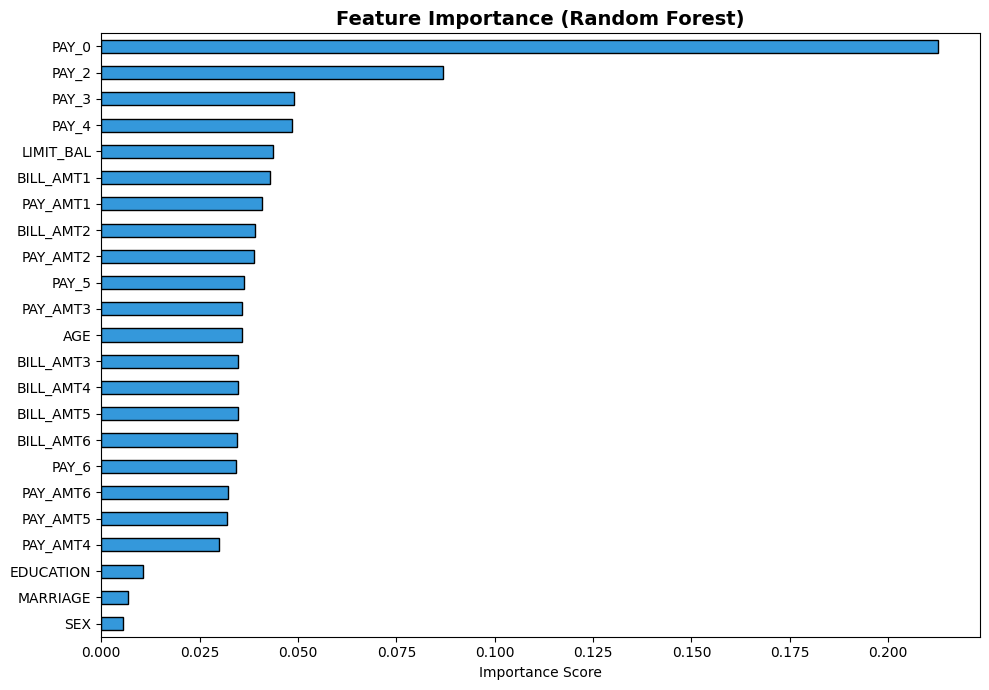

In [21]:
# Feature importance from Random Forest
feature_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_imp = feature_imp.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
feature_imp.plot(kind='barh', color='#3498db', edgecolor='black', ax=ax)
ax.set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [22]:
# Save the results table as CSV for the Streamlit app
results_df.to_csv('model/model_results.csv')
print('Results saved to model/model_results.csv')

# Save feature names for the Streamlit app
joblib.dump(list(X.columns), 'model/feature_names.pkl')
print('Feature names saved to model/feature_names.pkl')

print('\n✅ All 6 models trained, evaluated, and saved successfully!')
print(f'\nFiles in model/ directory:')
for f in sorted(os.listdir('model')):
    size = os.path.getsize(f'model/{f}')
    print(f'  📦 {f} ({size/1024:.1f} KB)')

Results saved to model/model_results.csv
Feature names saved to model/feature_names.pkl

✅ All 6 models trained, evaluated, and saved successfully!

Files in model/ directory:
  📦 decision_tree.pkl (9.5 KB)
  📦 feature_names.pkl (0.2 KB)
  📦 knn.pkl (4500.8 KB)
  📦 logistic_regression.pkl (1.0 KB)
  📦 model_results.csv (0.4 KB)
  📦 naive_bayes.pkl (1.5 KB)
  📦 random_forest.pkl (15070.8 KB)
  📦 scaler.pkl (1.6 KB)
  📦 xgboost.pkl (344.0 KB)
